## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [11]:
children(m)[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   

In [13]:
nn.Conv2d?

In [14]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [17]:
learn = ConvLearner.from_model_data(m, data)

In [18]:
learn.freeze_to(-4)

In [19]:
m[-1].trainable

True

In [20]:
m[-4].trainable

True

In [21]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.223413   0.162438   0.985352  



[0.16243751, 0.9853515625]

In [22]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.099271   0.106521   0.989746  



[0.10652093, 0.98974609375]

## CAM

In [23]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [24]:
x,y = next(iter(data.val_dl))
x,y = x[None,1], y[None,1]

vx = Variable(x.cuda(), requires_grad=True)

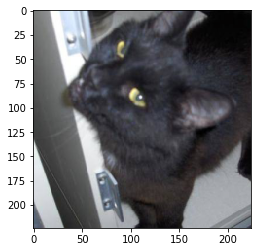

In [25]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [15]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([ 1.,  0.], dtype=float32)

In [16]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

In [23]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[ 0.06796,  0.09529,  0.04571,  0.02226,  0.01783,  0.02682,  0.     ],
       [ 0.18074,  0.25366,  0.21349,  0.17134,  0.12896,  0.07998,  0.02269],
       [ 0.32468,  0.53808,  0.58196,  0.51675,  0.36953,  0.20348,  0.06563],
       [ 0.4753 ,  0.82032,  0.93738,  0.84066,  0.58015,  0.30568,  0.09089],
       [ 0.53621,  0.90491,  1.     ,  0.87108,  0.60574,  0.33723,  0.11391],
       [ 0.44609,  0.70038,  0.72927,  0.60194,  0.42627,  0.26258,  0.10247],
       [ 0.21954,  0.3172 ,  0.30497,  0.21987,  0.15255,  0.08741,  0.00709]], dtype=float32)

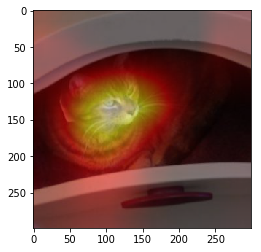

In [22]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
lr=np.array([1e-6,1e-4,1e-2])

In [40]:
learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.02049  0.01577  0.99405]                         
[ 1.       0.01648  0.0137   0.99554]                          



In [41]:
accuracy(*learn.TTA())

0.996

In [42]:
learn.fit(lr, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.01243  0.01535  0.99554]                          
[ 1.       0.0128   0.01507  0.99554]                          



In [43]:
accuracy(*learn.TTA())

0.99650000000000005